<center> <h1> SENTIMENT ANALYSIS FOR TRIPADVISOR
</h1> </center>

# Installing libraries

In [ ]:
!pip install underthesea
!pip install gensim==4.1.2
!pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 20.0 MB/s 
     |████████████████████████████████| 965 kB 60.4 MB/s 
     |████████████████████████████████| 235 kB 71.9 MB/s 
     |████████████████████████████████| 581 kB 69.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 302 kB 22.1 MB/s 
     |████████████████████████████████| 6.8 MB 47.5 MB/s 
     |████████████████████████████████| 269 kB 58.0 MB/s 
     |████████████████████████████████| 248 kB 10.9 MB/s 
     |███████████████████████

# Import necessary libraries

In [ ]:
import nltk
import underthesea
import string
import pickle
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_colwidth', 120)
sns.set_style('darkgrid')
sns.set(font_scale=1.4)

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/My Drive/MDS0_k278_VuThiHa/Cau_3/'

/content/gdrive/My Drive/MDS0_k278_VuThiHa/Cau_3


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from lazypredict.Supervised import LazyClassifier

In [ ]:
##LOAD EMOJICON
file = open('files/emojicon.txt', 'r', encoding="utf8")
emoji_lst = file.read().split('\n')
emoji_dict = {}
for line in emoji_lst:
    key, value = line.split('\t')
    emoji_dict[key] = str(value)
file.close()
#################
#LOAD TEENCODE
file = open('files/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()
###############
#LOAD TRANSLATE ENGLISH -> VNMESE
file = open('files/english-vnmese.txt', 'r', encoding="utf8")
english_lst = file.read().split('\n')
english_dict = {}
for line in english_lst:
    key, value = line.split('\t')
    english_dict[key] = str(value)
file.close()
################
#LOAD wrong words
file = open('files/wrong-word.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()
#################
#LOAD STOPWORDS
file = open('files/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

In [ ]:
def process_text(text, emoji_dict, teen_dict, wrong_lst):
    document = text.lower()
    document = document.replace("’",'')
    document = regex.sub(r'\.+', ".", document)
    new_sentence =''
    for sentence in sent_tokenize(document):
        # if not(sentence.isascii()):
        ###### CONVERT EMOJICON
        sentence = ''.join(emoji_dict[word]+' ' if word in emoji_dict else word for word in list(sentence))
        ###### CONVERT TEENCODE
        sentence = ' '.join(teen_dict[word] if word in teen_dict else word for word in sentence.split())
        ###### DEL Punctuation & Numbers
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        sentence = ' '.join(regex.findall(pattern,sentence))
        ###### DEL wrong words   
        sentence = ' '.join('' if word in wrong_lst else word for word in sentence.split())
        new_sentence = new_sentence+ sentence + '. '                    
    document = new_sentence  
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

# Load data

In [ ]:
data = pd.read_excel("review_full_text_tripadvisor_raw.xlsx", index_col = 0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82380 entries, Hotel des Arts Saigon Mgallery to Khai Hoan Hotel
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_name  82380 non-null  object
 1   title          82378 non-null  object
 2   full_content   82380 non-null  object
 3   rating         82380 non-null  object
 4   rating_new     82380 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [ ]:
data.head(50)

,customer_name,title,full_content,rating,rating_new
hotel_name,,,,,
Hotel des Arts Saigon Mgallery,Anh Tuấn L,Quá Tuyệt Vời Khi Ở Des Arts Sài Gòn,#HôtelDesArtsSaiGon là một sự trải nghiệm tuyệt vời khi mình ghé qua Sài Gòn. Nhân viên thân thiện và ai cũng tươi ...,bubble_50,5
Hotel des Arts Saigon Mgallery,TRƯƠNG BẰNG,Đáng đồng tiền!,"Dịch vụ cao cấp, phong cách chuyên nghiệp & tận tâm, tuy nhiên giá vẫn còn hơi cao, 5 sao mà! Thích hợp với dân busi...",bubble_50,5
Hotel des Arts Saigon Mgallery,Phong Thu Vu,huyền bí và ấn tượng,"vài dòng note lại về #Mgalery huyền bí... khác với đa phần các khách sạn khác, bạn sẽ rất dễ đi lướt qua #HôtelDesAr...",bubble_50,5
Hotel des Arts Saigon Mgallery,monkeyminhvn,love decor and service,Mình rất thích ngắm mái vòm và những khung cửa sổ được bo tròn với những hàng cây xanh um rất thư thái lắm ! Các bạn...,bubble_50,5
Hotel des Arts Saigon Mgallery,Ngoc Dung P,"Dễ thương, ấm cúng","Ks không lớn lắm nhưng có lối trang trí ấm cúng, sang trọng. Buffet khá ngon, nhân viên rất thân thiện. Cafe sân thư...",bubble_40,4
Hotel des Arts Saigon Mgallery,Thichan n,Tốt!,"Khách sạn hơi nhỏ so với tiêu chuẩn 5* nhưng tinh tế, ấm cúng và đẹp. Nhân viên thân thiện, nhiệt tình. Đồ ăn ở soci...",bubble_50,5
Hotel des Arts Saigon Mgallery,TrangChuppy,"Khách sạn đẹp, tiện nghi, hiện đại","Khách sạn đẹp, tiện nghi, nhân viên thân thiện với khách :) Hệ thống tiện nghi hiện đại, phòng gym, bể bơi đẹp :) ...",bubble_50,5
Hotel des Arts Saigon Mgallery,Emy N,Ngày sinh nhật đáng nhớ,"Phòng thiết kế đẹp, dịch vụ tốt, nhân viên rất lịch sự và thân thiện. Tuy nhiên quầy bar trên rooftop không có đèn h...",bubble_50,5
Hotel des Arts Saigon Mgallery,Mây Nguyễn,Vị trí trung tâm,"Khách sạn nằm ngay bên hông nhà văn hoá Thanh Niên, gần Trung tâm Thương mại Diamond. Thiết kế đơn giản nhưng đẹp và...",bubble_40,4


In [ ]:
data.columns

Index(['customer_name', 'title', 'full_content', 'rating', 'rating_new'], dtype='object')

In [ ]:
data.shape

(82380, 5)

In [ ]:
df = data[['full_content', 'rating_new']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82380 entries, Hotel des Arts Saigon Mgallery to Khai Hoan Hotel
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   full_content  82380 non-null  object
 1   rating_new    82380 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.9+ MB


In [ ]:
df.isnull().sum()

full_content    0
rating_new      0
dtype: int64

=> Không có dữ liệu null

In [ ]:
df.groupby(['rating_new']).count()

,full_content
rating_new,
1,4438
2,2776
3,5507
4,13256
5,56403


=> Các Class ở đây đang bị mất cân bằng dữ liệu.

In [ ]:
df.head(5)

,full_content,rating_new
hotel_name,,
Hotel des Arts Saigon Mgallery,#HôtelDesArtsSaiGon là một sự trải nghiệm tuyệt vời khi mình ghé qua Sài Gòn. Nhân viên thân thiện và ai cũng tươi ...,5
Hotel des Arts Saigon Mgallery,"Dịch vụ cao cấp, phong cách chuyên nghiệp & tận tâm, tuy nhiên giá vẫn còn hơi cao, 5 sao mà! Thích hợp với dân busi...",5
Hotel des Arts Saigon Mgallery,"vài dòng note lại về #Mgalery huyền bí... khác với đa phần các khách sạn khác, bạn sẽ rất dễ đi lướt qua #HôtelDesAr...",5
Hotel des Arts Saigon Mgallery,Mình rất thích ngắm mái vòm và những khung cửa sổ được bo tròn với những hàng cây xanh um rất thư thái lắm ! Các bạn...,5
Hotel des Arts Saigon Mgallery,"Ks không lớn lắm nhưng có lối trang trí ấm cúng, sang trọng. Buffet khá ngon, nhân viên rất thân thiện. Cafe sân thư...",4


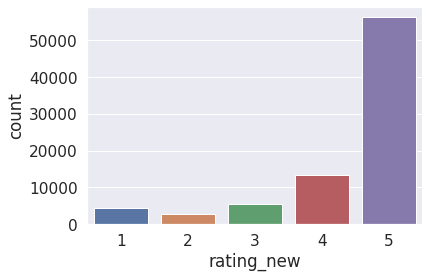

In [ ]:
sns.countplot(df.rating_new)

=> Do dữ liệu bị mất cân bằng nên gom thành 2 nhóm như đề xuất bên dưới

Chia thành 2 nhóm
- negative: 1,2,3 --> 0
- positive: 4,5 --> 1

In [ ]:
df['review_class'] = ['negative' if a <4 else 'positive' for a in df.rating_new]

In [ ]:
df.review_class.value_counts()

positive    69659
negative    12721
Name: review_class, dtype: int64

# Xử Lý NLP Process

## Check out positive comments

In [ ]:
df[df.review_class=='positive'].head(10)

,full_content,rating_new,review_class
hotel_name,,,
Hotel des Arts Saigon Mgallery,#HôtelDesArtsSaiGon là một sự trải nghiệm tuyệt vời khi mình ghé qua Sài Gòn. Nhân viên thân thiện và ai cũng tươi ...,5,positive
Hotel des Arts Saigon Mgallery,"Dịch vụ cao cấp, phong cách chuyên nghiệp & tận tâm, tuy nhiên giá vẫn còn hơi cao, 5 sao mà! Thích hợp với dân busi...",5,positive
Hotel des Arts Saigon Mgallery,"vài dòng note lại về #Mgalery huyền bí... khác với đa phần các khách sạn khác, bạn sẽ rất dễ đi lướt qua #HôtelDesAr...",5,positive
Hotel des Arts Saigon Mgallery,Mình rất thích ngắm mái vòm và những khung cửa sổ được bo tròn với những hàng cây xanh um rất thư thái lắm ! Các bạn...,5,positive
Hotel des Arts Saigon Mgallery,"Ks không lớn lắm nhưng có lối trang trí ấm cúng, sang trọng. Buffet khá ngon, nhân viên rất thân thiện. Cafe sân thư...",4,positive
Hotel des Arts Saigon Mgallery,"Khách sạn hơi nhỏ so với tiêu chuẩn 5* nhưng tinh tế, ấm cúng và đẹp. Nhân viên thân thiện, nhiệt tình. Đồ ăn ở soci...",5,positive
Hotel des Arts Saigon Mgallery,"Khách sạn đẹp, tiện nghi, nhân viên thân thiện với khách :) Hệ thống tiện nghi hiện đại, phòng gym, bể bơi đẹp :) ...",5,positive
Hotel des Arts Saigon Mgallery,"Phòng thiết kế đẹp, dịch vụ tốt, nhân viên rất lịch sự và thân thiện. Tuy nhiên quầy bar trên rooftop không có đèn h...",5,positive
Hotel des Arts Saigon Mgallery,"Khách sạn nằm ngay bên hông nhà văn hoá Thanh Niên, gần Trung tâm Thương mại Diamond. Thiết kế đơn giản nhưng đẹp và...",4,positive


Check out negative comments

In [ ]:
df[df.review_class=='negative'].head(10)

,full_content,rating_new,review_class
hotel_name,,,
Lotte Hotel Saigon,"Đây là một khách sạn lớn và hơi vô tư. Tôi sẽ ở lại các nhân viên rất đáng yêu và hữu ích. Tuy nhiên, trong chuyến t...",3,negative
Hotel Nikko Saigon,"Sorry guys I’m so lazy to translate now, will be back later with translation. This is for Vietnamese diners at the m...",3,negative
Hotel Nikko Saigon,"Dịch vụ truy cập 1, Trao đổi giá phòng ngày đặt phòng của tôi 7/20 Giữa 7/21 giao tiếp rất lâu! 2, Đổi chúng tôi 1...",3,negative
Fusion Suites Saigon,Cảm quan đầu tiên bước vào khách sạn hơi thất vọng so với hình ảnh quảng cáo trên mạng. Nhưg ấn tượng được các bạn n...,3,negative
Fusion Suites Saigon,"Fusion Sài Gòn Đây là một khách sạn nhỏ xinh xắn, vui nhộn, nằm cách Tây Bắc trung tâm thành phố một chút, nhưng tru...",3,negative
Fusion Suites Saigon,Ưu điểm: Giường lớn thoải mái Nhiều nước nóng Bữa sáng ngon lành Một căn phòng lớn với một cửa sổ hình ảnh lớn N...,3,negative
Liberty Central Saigon Riverside Hotel,Cảm giác đầu tiên đến với Liberty Riverside Hotel trong những ngày cận kề tết Nguyên đán 2017 thật dễ chịu. Vị trí đ...,3,negative
Pullman Saigon Centre,"Phòng ốc ở đây cũng ổn, tuy hơi nhỏ nhưng có view đẹp. Hồ bơi nhỏ, món ăn in room dining không đa dạng lắm, nhân viê...",3,negative
Pullman Saigon Centre,Điểm nổi bật của kỳ nghỉ của chúng tôi là bữa sáng của chúng tôi với một loạt các sản phẩm chất lượng tốt. Các phòng...,3,negative


In [ ]:
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
import string

In [ ]:
df['content_process'] = df['full_content'].apply(lambda x: process_text(x, emoji_dict, teen_dict, wrong_lst))

In [ ]:
# Chuẩn hóa unicode tiếng việt
def loaddicchar():
    uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
    unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
 
# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def covert_unicode(txt):
    dicchar = loaddicchar()
    return regex.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [ ]:
# Bước 2: chuẩn hóa Unicode tiếng Việt
df['content_process_Unicode'] = df['content_process'].apply(lambda s: covert_unicode(s))

In [ ]:
df['content_process_Unicode']

hotel_name
Hotel des Arts Saigon Mgallery    hôteldesartssaigon là một sự trải nghiệm tuyệt vời mình ghé sài gòn. nhân viên thân thiện và cũng tươi luông. đặc bi...
Hotel des Arts Saigon Mgallery    dịch vụ cấp cách chuyên nghiệp tận tâm nhiên giá vẫn còn hơi mà. thích hợp với dân hoặc nhà có điều kiện chống chỉ đ...
Hotel des Arts Saigon Mgallery    vài dòng chú ý lại về huyền bí. khác với đa phần các khách sạn khác bạn sẽ rất dễ đi lướt bởi hàng cây trước khách s...
Hotel des Arts Saigon Mgallery    mình rất thích ngắm mái vòm và những cửa sổ được tròn với những hàng cây um rất thư thái lắm. các bạn nhớ lên tầng t...
Hotel des Arts Saigon Mgallery    khách sạn không lớn lắm nhưng có lối trí ấm cúng sang trọng. khá nhân viên rất thân thiện. sân thượng có cảnh đẹp. n...
                                                                                           ...                                                           
Nha co Homestay                   tụi mình đi đoàn người đặt phòn

In [ ]:
df.head(15)

,full_content,rating_new,review_class,content_process,content_process_Unicode
hotel_name,,,,,
Hotel des Arts Saigon Mgallery,#HôtelDesArtsSaiGon là một sự trải nghiệm tuyệt vời khi mình ghé qua Sài Gòn. Nhân viên thân thiện và ai cũng tươi ...,5,positive,hôteldesartssaigon là một sự trải nghiệm tuyệt vời mình ghé sài gòn. nhân viên thân thiện và cũng tươi luông. đặc bi...,hôteldesartssaigon là một sự trải nghiệm tuyệt vời mình ghé sài gòn. nhân viên thân thiện và cũng tươi luông. đặc bi...
Hotel des Arts Saigon Mgallery,"Dịch vụ cao cấp, phong cách chuyên nghiệp & tận tâm, tuy nhiên giá vẫn còn hơi cao, 5 sao mà! Thích hợp với dân busi...",5,positive,dịch vụ cấp cách chuyên nghiệp tận tâm nhiên giá vẫn còn hơi mà. thích hợp với dân hoặc nhà có điều kiện chống chỉ đ...,dịch vụ cấp cách chuyên nghiệp tận tâm nhiên giá vẫn còn hơi mà. thích hợp với dân hoặc nhà có điều kiện chống chỉ đ...
Hotel des Arts Saigon Mgallery,"vài dòng note lại về #Mgalery huyền bí... khác với đa phần các khách sạn khác, bạn sẽ rất dễ đi lướt qua #HôtelDesAr...",5,positive,vài dòng chú ý lại về huyền bí. khác với đa phần các khách sạn khác bạn sẽ rất dễ đi lướt bởi hàng cây trước khách s...,vài dòng chú ý lại về huyền bí. khác với đa phần các khách sạn khác bạn sẽ rất dễ đi lướt bởi hàng cây trước khách s...
Hotel des Arts Saigon Mgallery,Mình rất thích ngắm mái vòm và những khung cửa sổ được bo tròn với những hàng cây xanh um rất thư thái lắm ! Các bạn...,5,positive,mình rất thích ngắm mái vòm và những cửa sổ được tròn với những hàng cây um rất thư thái lắm. các bạn nhớ lên tầng t...,mình rất thích ngắm mái vòm và những cửa sổ được tròn với những hàng cây um rất thư thái lắm. các bạn nhớ lên tầng t...
Hotel des Arts Saigon Mgallery,"Ks không lớn lắm nhưng có lối trang trí ấm cúng, sang trọng. Buffet khá ngon, nhân viên rất thân thiện. Cafe sân thư...",4,positive,khách sạn không lớn lắm nhưng có lối trí ấm cúng sang trọng. khá nhân viên rất thân thiện. sân thượng có cảnh đẹp. n...,khách sạn không lớn lắm nhưng có lối trí ấm cúng sang trọng. khá nhân viên rất thân thiện. sân thượng có cảnh đẹp. n...
Hotel des Arts Saigon Mgallery,"Khách sạn hơi nhỏ so với tiêu chuẩn 5* nhưng tinh tế, ấm cúng và đẹp. Nhân viên thân thiện, nhiệt tình. Đồ ăn ở soci...",5,positive,khách sạn hơi nhỏ với tiêu chuẩn nhưng tế ấm cúng và đẹp. nhân viên thân thiện nhiệt tình. đồ ăn ở social và đồ ăn p...,khách sạn hơi nhỏ với tiêu chuẩn nhưng tế ấm cúng và đẹp. nhân viên thân thiện nhiệt tình. đồ ăn ở social và đồ ăn p...
Hotel des Arts Saigon Mgallery,"Khách sạn đẹp, tiện nghi, nhân viên thân thiện với khách :) Hệ thống tiện nghi hiện đại, phòng gym, bể bơi đẹp :) ...",5,positive,khách sạn đẹp tiện nhân viên thân thiện với khách hệ thống tiện hiện đại phòng bể bơi đẹp khách sạn gần tâm có thể đ...,khách sạn đẹp tiện nhân viên thân thiện với khách hệ thống tiện hiện đại phòng bể bơi đẹp khách sạn gần tâm có thể đ...
Hotel des Arts Saigon Mgallery,"Phòng thiết kế đẹp, dịch vụ tốt, nhân viên rất lịch sự và thân thiện. Tuy nhiên quầy bar trên rooftop không có đèn h...",5,positive,phòng thiết kế đẹp dịch vụ tốt nhân viên rất lịch sự và thân thiện. nhiên quầy trên không có đèn hơi tối. nhưng âm n...,phòng thiết kế đẹp dịch vụ tốt nhân viên rất lịch sự và thân thiện. nhiên quầy trên không có đèn hơi tối. nhưng âm n...
Hotel des Arts Saigon Mgallery,"Khách sạn nằm ngay bên hông nhà văn hoá Thanh Niên, gần Trung tâm Thương mại Diamond. Thiết kế đơn giản nhưng đẹp và...",4,positive,khách sạn nằm bên hông nhà văn hoá niên gần tâm thương mại . thiết kế đơn giản nhưng đẹp và sang trọng. nhiên mô của...,khách sạn nằm bên hông nhà văn hoá niên gần tâm thương mại . thiết kế đơn giản nhưng đẹp và sang trọng. nhiên mô của...


In [ ]:
df.tail(15)

,full_content,rating_new,review_class,content_process,content_process_Unicode
hotel_name,,,,,
Mị Homestay,Hóa ra đã kiểm tra một số đánh giá tuyệt vời trên các trang web khác nhau trước khi bắt đầu chu trình vòng lặp ha Gi...,2,negative,hóa đã kiểm một số đánh giá tuyệt vời trên các khác trước bắt đầu trình vòng lặp . tích cực giá rẻ đạp của tôi vào c...,hóa đã kiểm một số đánh giá tuyệt vời trên các khác trước bắt đầu trình vòng lặp . tích cực giá rẻ đạp của tôi vào c...
Bee House Homestay,100 điểm cho nhân viên của họ với sự hiếu khách và thân thiện tuyệt vời! Họ sẵn sàng giữ hành lý của chúng tôi an to...,4,positive,điểm cho nhân viên của họ với sự hiếu khách và thân thiện tuyệt vời. họ sẵn sàng giữ hành lý của chúng tôi toàn và t...,điểm cho nhân viên của họ với sự hiếu khách và thân thiện tuyệt vời. họ sẵn sàng giữ hành lý của chúng tôi toàn và t...
Bee House Homestay,"Những người tuyệt vời, họ là những người rất hữu ích, phòng sạch sẽ với tầm nhìn tuyệt đẹp, quán cà phê tuyệt vời và...",5,positive,những người tuyệt vời họ là những người rất hữu ích phòng sạch sẽ với tầm nhìn tuyệt đẹp quán cà phê tuyệt vời và cá...,những người tuyệt vời họ là những người rất hữu ích phòng sạch sẽ với tầm nhìn tuyệt đẹp quán cà phê tuyệt vời và cá...
Thien Thanh Hotel,Chúng tôi đã đến khách sạn này như là một đêm ở trên đường về phía bắc. Hai ngôi sao và tổng hợp nó thật sự. Không c...,3,negative,chúng tôi đã đến khách sạn này như là một đêm ở trên đường về phía bắc. ngôi và tổng hợp nó thật sự. không cấp bữa ă...,chúng tôi đã đến khách sạn này như là một đêm ở trên đường về phía bắc. ngôi và tổng hợp nó thật sự. không cấp bữa ă...
Khách Sạn Thùy Dung,"Chúng tôi có một căn phòng khá lớn với bồn tắm. Các phòng là giá rẻ, sạch sẽ và với bữa ăn sáng. Đối với bữa sáng, d...",4,positive,chúng tôi có một căn phòng khá lớn với bồn tắm. các phòng là giá rẻ sạch sẽ và với bữa ăn sáng. đối với bữa sáng khá...,chúng tôi có một căn phòng khá lớn với bồn tắm. các phòng là giá rẻ sạch sẽ và với bữa ăn sáng. đối với bữa sáng khá...
Khách Sạn Thùy Dung,Chúng tôi chỉ ở lại một đêm tại nơi nghỉ này trước khi lên đường đi về phía bắc. Phòng của chúng tôi là căn bản như...,5,positive,chúng tôi chỉ ở lại một đêm tại nơi nghỉ này trước lên đường đi về phía bắc. phòng của chúng tôi là căn bản nhưng đư...,chúng tôi chỉ ở lại một đêm tại nơi nghỉ này trước lên đường đi về phía bắc. phòng của chúng tôi là căn bản nhưng đư...
Khách Sạn Thùy Dung,"Khách sạn này đẹp, sạch sẽ và được trang bị tốt. Unfortunatelly những thứ không nói bất kỳ tiếng Anh mặc dù họ rất t...",3,negative,khách sạn này đẹp sạch sẽ và được bị tốt. những thứ không nói bất kỳ tiếng mặc dù họ rất tốt đẹp. ngoài không gồm bữ...,khách sạn này đẹp sạch sẽ và được bị tốt. những thứ không nói bất kỳ tiếng mặc dù họ rất tốt đẹp. ngoài không gồm bữ...
Khách Sạn Thùy Dung,Chúng tôi đã dừng chân ở Hà Giang bởi vì chúng tôi muốn làm vòng đua xe máy. Chúng tôi đã đi đến khách sạn đó bởi vì...,2,negative,chúng tôi đã dừng chân ở hà bởi vì chúng tôi muốn làm vòng đua máy. chúng tôi đã đi đến khách sạn đó bởi vì nó mới đ...,chúng tôi đã dừng chân ở hà bởi vì chúng tôi muốn làm vòng đua máy. chúng tôi đã đi đến khách sạn đó bởi vì nó mới đ...
Cao Bo Homestay,Tôi đã đến thăm Cao Bồ với gia đình của tôi (đối tác và hai cô gái tuổi từ 13 đến 10). Chúng tôi yêu thích ở với Ngū...,5,positive,tôi đã đến thăm bồ với đình của tôi đối tác và cô gái tuổi từ đến. chúng tôi yêu thích ở với và đình của ấy. chúng t...,tôi đã đến thăm bồ với đình của tôi đối tác và cô gái tuổi từ đến. chúng tôi yêu thích ở với và đình của ấy. chúng t...


Data Cleaning

We will clean the data with the following steps:
- Translating some common English words to Vietnamese
- Replace some emojis to "positive","negative" depending on emoji's emotion
- Remove number and punctuation
- Remove duplicated letters at the end of words (ex: tốttttt --> tốt)
- Replace words that are often abbreviated or misspelled
- Handle negative (ex: __không__ tốt --> notpositive, __không__ tệ --> notnegative)
- Word segmentation (ex: chất lượng --> chất_lượng)

Each step will be a custom transformers created by using sklearn, we will use these transformers to build a preprocessing pipeline for convenience

In [ ]:
# Dictionary for translating English words to Vietnamese
eng_viet_dict = {'free': 'miễn phí', 'review': 'đánh giá', 'full': 'đầy đủ', 'store': 'cửa hàng', 'comment': 'nhận xét', 'very': 'rất',
                 'cute': 'dễ thương', 'good': 'tốt', 'bad': 'tệ', 'thanks': 'cảm ơn', 'tks': 'cảm ơn', 'thank': 'cảm ơn', 'thx': 'cảm ơn',
                 'recommend': 'khuyến khích', 'satisfied': 'hài lòng', 'like': 'thích', 'time': 'thời gian',
                 'perfect': 'tuyệt vời', 'fake': 'giả', 'real': 'thật', 'auth': 'thật', 'authentic': 'thật',
                 'nice': 'tốt', 'rep': 'trả lời', 'but': 'nhưng', 'date': 'hạn sử dụng', 'app': 'ứng dụng',
                 'bookmark': 'đánh dấu trang', 'pr': 'quảng cáo', 'not': 'không', 'product': 'sản phẩm', 'amazing': 'tuyệt vời'}


# Dictionary for replacing some emojis to 'positive', 'neutral', 'negative' depending on emoji's emotion
emoji_dict = {'👌': ' positive ', '👍🏻': ' positive ', '👍': ' positive ', '😁': ' positive ', '🤗': ' positive ', '🥰': ' positive ', '🤣': ' positive ', '😆': ' positive ',
              '😊': ' positive ', '🥳': ' positive ', '😍': ' positive ', '🙂': ' positive ', '🤩': ' positive ', '😚': ' positive ', ':D': ' positive ', '😘': ' positive ',
              '💯': ' positive ', '❤️': ' positive ', '😃': ' positive ', '<3': ' positive ', '😉': ' positive ', '😇': ' positive ', '😋': ' positive ', '💚': ' positive ',
              '😗': ' positive ', '😙': ' positive ', '😀': ' positive ',
              '😳': ' neutral ', '😅': ' neutral ',
              '🤒': ' negative ' , '😞': ' negative ', '😢': ' negative ', '😭': ' negative ', '😒': ' negative ', '😑': ' negative ', '😌': ' negative ',
              '😡': ' negative ', '🙃': ' negative ', '😔': ' negative ', '🤕': ' negative ',
              '🥴': ' negative ', '😩': ' negative ', '😟': ' negative '}


# Dictionary for replacing words that are often abbreviated or misspelled
wrong_correct_dict = {'oke': 'ok', 'okie': 'ok', 'okey': 'ok', 'okê': 'ok', 'okela': 'ok', 'oki': 'ok', 'okay': 'ok', 'ôke': 'ok',
                      'đc': 'được', 'đx': 'được', 'dc': 'được', 'sp': 'sản phẩm', 'spham': 'sản phẩm', 'sd': 'sử dụng',
                      'sdung': 'sử dụng', 'hsd': 'hạn sử dụng', 'sx': 'sản xuất', 'trl': 'trả lời', 'iu': 'yêu',
                      'bt': 'bình thường', 'bthuong': 'bình thường', 'bth': 'bình thường', 't': 'tôi', 'tui': 'tôi', 'mik': 'mình', 'mh': 'mình',
                      'k': 'không', 'ko': 'không', 'k0': 'không', 'khg': 'không', 'hok': 'không', 'kg': 'không', 'hk': 'không', 'khong': 'không',
                      'h0k': 'không', 'hong': 'không', 'hổng': 'không', 'chất lg': 'chất lượng',
                      'dt': 'điện thoại', 'đt': 'điện thoại', 'đth': 'điện thoại', 'thik': 'thích', 'thix': 'thích', 'cug': 'cũng',
                      'nhg': 'nhưng', 'nhưg': 'nhưng', 'nhx': 'nhưng', 'nma': 'nhưng mà', 'qc': 'quảng cáo', 'nãn': 'nản', 'mn': 'mọi người',
                      'mng': 'mọi người', 'm.n': 'mọi người', 'tg': 'thời gian', 'tgian': 'thời gian', 'hs': 'học sinh', 'sv': 'sinh viên',
                      'gv': 'giáo viên', 'hssv': 'học sinh sinh viên', 'vs': 'với', 'ms': 'mới', 'tp': 'thành phố',
                      'dth': 'dễ thương', 'dthg': 'dễ thương', '1\*': '1 sao', '2\*': '2 sao', '3\*': '3 sao', '4\*': '4 sao', '5\*': '5 sao',
                      'r': 'rồi', 'hnay': 'hôm nay', 'onl': 'online', 'sl': 'số lượng', 'hdsd': 'hướng dẫn sử dụng', 'trc': 'trước',
                      'mk': 'mình', 'cx': 'cũng', 'lun': 'luôn', 'tot': 'tốt', 'te': 'tệ', 'xau': 'xấu', 'dep': 'đẹp', 'cham': 'chậm', 'thich': 'thích',
                      'nd': 'nội dung', 'ndung': 'nội dung', 'cty': 'công ty', 'uh': 'ừ', 'uhm': 'ừ', 'ah': 'à', 'qá': 'quá', 'bít': 'biết', 'bik': 'biết'}

Create a custom transformer to translate some common English words to Vietnamese

In [ ]:
class TranslateEngViet(BaseEstimator, TransformerMixin):
    def __init__(self, dictionary):
        super().__init__()
        self.dictionary = dictionary

    def fit(self, series):
        return self

    def transform(self, series):
        for k, v in self.dictionary.items():
            series = series.str.replace(k, v, case=False)
        return series

Create a custom transformer to replace some emojis to "positive", "neutral", "negative" depending on emoji's emotion

In [ ]:
class ReplaceEmoji(BaseEstimator, TransformerMixin):
    def __init__(self, dictionary):
        super().__init__()
        self.dictionary = dictionary

    def fit(self, series):
        return self

    def transform(self, series):
        for k, v in self.dictionary.items():
            series = series.str.replace(k, v, case=False)
        return series

Create a custom transformer to remove punctuation

In [ ]:
class RemoveNumberPunctuation(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, series):
        return self

    def transform(self, series):
        series = series.apply(lambda x: x.translate(str.maketrans('', '', '0123456789')))
        series = series.apply(lambda x: x.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation))))
        return series

Create a custom transformer to remove duplicated letters at the end of words (ex: tốttttt --> tốt)

In [ ]:
class RemoveDupWords(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, series):
        return self

    def transform(self, series):
        series = series.apply(lambda x: re.sub(r'([A-Z])\1+', lambda c: c.group(1).upper(), x, flags=re.IGNORECASE))
        return series

Create a custom transformer to replace words that are often abbreviated or misspelled

In [ ]:
def word_replace(mapper, word_list):
    for k, v in mapper.items():
        word_list = [v if k==w else w for w in word_list]
    return word_list


class ReplaceAbbreWords(BaseEstimator, TransformerMixin):
    def __init__(self, dictionary):
        super().__init__()
        self.dictionary = dictionary

    def fit(self, series):
        return self

    def transform(self, series):
        series = series.apply(lambda x: x.lower())
        series = series.apply(lambda x: nltk.word_tokenize(x))
        series = series.apply(lambda x: word_replace(self.dictionary, x))
        series = series.apply(lambda x: ' '.join(x))
        return series

Create a custom transformer to handle negative (ex: __không tốt --> notpositive, không tệ --> notnegative)_

In [ ]:
def negative_handle(text):
    words = underthesea.word_tokenize(text)
    len_words = len(words)
    for i in range(len_words):
        word_ = words[i]
        if word_ in ['không', 'chẳng', 'chưa']:
            numb_word = 2 if len_words - i - 1 >= 4 else len_words - i - 1

            for j in range(numb_word):
                if words[i + j + 1] in ['hài lòng', 'tốt', 'hay', 'ok', 'ổn', 'đẹp']:
                    words[i] = 'notpositive'
                    words[i + j + 1] = ''

                if words[i + j + 1] in ['tệ', 'lỗi', 'xấu', 'kém']:
                    words[i] = 'notnegative'
                    words[i + j + 1] = ''                    
    return words  


class HandleNegative(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self, series):
        return self

    def transform(self, series):
        series = series.apply(lambda x: negative_handle(x))
        series = series.apply(lambda x: ' '.join(x))
        return series  

Create a custom transformer for word segmentation

In [ ]:
class WordSegmentation(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()
        
    def fit(self, series):
        return self
    
    def transform(self, series):
        series = series.apply(lambda x: underthesea.word_tokenize(x, format='text'))
        return series

Finally, we build a pipeline for processing data

In [ ]:
preprocess_pipeline = Pipeline([('trans_eng_viet', TranslateEngViet(eng_viet_dict)),
                                ('replace_emoji', ReplaceEmoji(emoji_dict)),
                                ('remove_num_punctuation', RemoveNumberPunctuation()),
                                ('remove_dup_words', RemoveDupWords()),
                                ('replace_abbre_words', ReplaceAbbreWords(wrong_correct_dict)),
                                ('handle_negative', HandleNegative()),
                                ('word_segmentation', WordSegmentation())
                               ])

Apply the pipeline we've built to the comments

In [ ]:
df['tidy_comment'] = preprocess_pipeline.fit_transform(df['content_process_Unicode'])

In [ ]:
df.head(10)

,full_content,rating_new,review_class,content_process,content_process_Unicode,tidy_comment
hotel_name,,,,,,
Hotel des Arts Saigon Mgallery,#HôtelDesArtsSaiGon là một sự trải nghiệm tuyệt vời khi mình ghé qua Sài Gòn. Nhân viên thân thiện và ai cũng tươi ...,5,positive,hôteldesartssaigon là một sự trải nghiệm tuyệt vời mình ghé sài gòn. nhân viên thân thiện và cũng tươi luông. đặc bi...,hôteldesartssaigon là một sự trải nghiệm tuyệt vời mình ghé sài gòn. nhân viên thân thiện và cũng tươi luông. đặc bi...,hôteldesartsaigon là một sự trải_nghiệm tuyệt_vời mình ghé sài_gòn nhân_viên thân_thiện và cũng tươi luông đặc_biệt ...
Hotel des Arts Saigon Mgallery,"Dịch vụ cao cấp, phong cách chuyên nghiệp & tận tâm, tuy nhiên giá vẫn còn hơi cao, 5 sao mà! Thích hợp với dân busi...",5,positive,dịch vụ cấp cách chuyên nghiệp tận tâm nhiên giá vẫn còn hơi mà. thích hợp với dân hoặc nhà có điều kiện chống chỉ đ...,dịch vụ cấp cách chuyên nghiệp tận tâm nhiên giá vẫn còn hơi mà. thích hợp với dân hoặc nhà có điều kiện chống chỉ đ...,dịch_vụ cấp cách chuyên_nghiệp tận_tâm nhiên giá vẫn còn hơi mà thích_hợp với dân hoặc nhà có điều_kiện chống chỉ_đị...
Hotel des Arts Saigon Mgallery,"vài dòng note lại về #Mgalery huyền bí... khác với đa phần các khách sạn khác, bạn sẽ rất dễ đi lướt qua #HôtelDesAr...",5,positive,vài dòng chú ý lại về huyền bí. khác với đa phần các khách sạn khác bạn sẽ rất dễ đi lướt bởi hàng cây trước khách s...,vài dòng chú ý lại về huyền bí. khác với đa phần các khách sạn khác bạn sẽ rất dễ đi lướt bởi hàng cây trước khách s...,vài dòng chú_ý lại về huyền_bí khác với đa_phần các khách_sạn khác bạn sẽ rất dễ đi lướt bởi hàng cây trước khách_sạ...
Hotel des Arts Saigon Mgallery,Mình rất thích ngắm mái vòm và những khung cửa sổ được bo tròn với những hàng cây xanh um rất thư thái lắm ! Các bạn...,5,positive,mình rất thích ngắm mái vòm và những cửa sổ được tròn với những hàng cây um rất thư thái lắm. các bạn nhớ lên tầng t...,mình rất thích ngắm mái vòm và những cửa sổ được tròn với những hàng cây um rất thư thái lắm. các bạn nhớ lên tầng t...,mình rất thích ngắm mái vòm và những cửa_sổ được tròn với những hàng cây um rất thư_thái lắm các bạn nhớ lên tầng th...
Hotel des Arts Saigon Mgallery,"Ks không lớn lắm nhưng có lối trang trí ấm cúng, sang trọng. Buffet khá ngon, nhân viên rất thân thiện. Cafe sân thư...",4,positive,khách sạn không lớn lắm nhưng có lối trí ấm cúng sang trọng. khá nhân viên rất thân thiện. sân thượng có cảnh đẹp. n...,khách sạn không lớn lắm nhưng có lối trí ấm cúng sang trọng. khá nhân viên rất thân thiện. sân thượng có cảnh đẹp. n...,khách_sạn không lớn lắm nhưng có lối trí ấm_cúng sang_trọng khá nhân_viên rất thân_thiện sân_thượng có cảnh đẹp nếu ...
Hotel des Arts Saigon Mgallery,"Khách sạn hơi nhỏ so với tiêu chuẩn 5* nhưng tinh tế, ấm cúng và đẹp. Nhân viên thân thiện, nhiệt tình. Đồ ăn ở soci...",5,positive,khách sạn hơi nhỏ với tiêu chuẩn nhưng tế ấm cúng và đẹp. nhân viên thân thiện nhiệt tình. đồ ăn ở social và đồ ăn p...,khách sạn hơi nhỏ với tiêu chuẩn nhưng tế ấm cúng và đẹp. nhân viên thân thiện nhiệt tình. đồ ăn ở social và đồ ăn p...,khách_sạn hơi nhỏ với tiêu_chuẩn nhưng tế ấm_cúng và đẹp nhân_viên thân_thiện nhiệt_tình đồ ăn ở social và đồ ăn phụ...
Hotel des Arts Saigon Mgallery,"Khách sạn đẹp, tiện nghi, nhân viên thân thiện với khách :) Hệ thống tiện nghi hiện đại, phòng gym, bể bơi đẹp :) ...",5,positive,khách sạn đẹp tiện nhân viên thân thiện với khách hệ thống tiện hiện đại phòng bể bơi đẹp khách sạn gần tâm có thể đ...,khách sạn đẹp tiện nhân viên thân thiện với khách hệ thống tiện hiện đại phòng bể bơi đẹp khách sạn gần tâm có thể đ...,khách_sạn đẹp tiện nhân_viên thân_thiện với khách hệ_thống tiện hiện_đại phòng bể_bơi đẹp khách_sạn gần tâm có_thể đ...
Hotel des Arts Saigon Mgallery,"Phòng thiết kế đẹp, dịch vụ tốt, nhân viên rất lịch sự và thân thiện. Tuy nhiên quầy bar trên rooftop không có đèn h...",5,positive,phòng thiết kế đẹp dịch vụ tốt nhân viên rất lịch sự và thân thiện.

In [ ]:
df_final = [['tidy_comment', 'rating_new', 'review_class']]

In [ ]:
df_final.head(10)

Visualization Foody Comments

In [ ]:
!pip install spacy
!pip install scattertext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.3 MB 12.1 MB/s 
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9309 sha256=d057bf84b4edd3c775b0641e82bcff1066288348f0e692ad08dc414357661f69
  Stored in directory: /root/.cache/pip/wheels/cb/19/58/4e8fdd0009a7f89dbce3c18fff2e0d0fa201d5cdfd16f113b7
Successfully built flashtext


In [ ]:
!pip install https://gitlab.com/trungtv/vi_spacy/-/raw/master/vi_core_news_lg/dist/vi_core_news_lg-0.0.1.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 254.5 MB 31 kB/s 
     |████████████████████████████████| 5.8 MB 8.8 MB/s 
     |████████████████████████████████| 10.1 MB 65.5 MB/s 
     |████████████████████████████████| 660 kB 15.0 MB/s 
  Created wheel for vi-core-news-lg: filename=vi_core_news_lg-0.0.1-py3-none-any.whl size=254513618 sha256=d733b088283474749098db0d0283a62e26056b66b095e26f3845a79a9a0376d9
  Stored in directory: /root/.cache/pip/wheels/e4/d9/90/dcbb25186a2c3335b17bc675f8dddcb43ecdfa4b400e8c91b0
Successfully built vi-core-news-lg
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: typer
    Found existing installation: typer 0.4.2
    Uninstalling typer-0.4.2:
      Successfully uninstalled typer-0.4.2
  Attemptin

Understanding the common words of each class by using WordCloud plot

Define color functions for aesthetic

In [ ]:
def orange_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    h = 23
    s = 100
    l = np.random.randint(25, 70)
    return "hsl({}, {}%, {}%)".format(h, s, l)

#def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
#    h = 0
#    s = 0
#    l = np.random.randint(20, 60)
#    return "hsl({}, {}%, {}%)".format(h, s, l)

def green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    h = 120
    s = 45
    l = np.random.randint(25, 65)
    return "hsl({}, {}%, {}%)".format(h, s, l)

Create documents of each class

In [ ]:
# Negative document
negative_doc = ' '.join([text for text in df[df.review_class=='negative']['tidy_comment']])

# Neutral document
#neutral_doc = ' '.join([text for text in df[df.review_class=='neutral']['tidy_comment']])

# Positive document
positive_doc = ' '.join([text for text in df[df.review_class=='positive']['tidy_comment']])

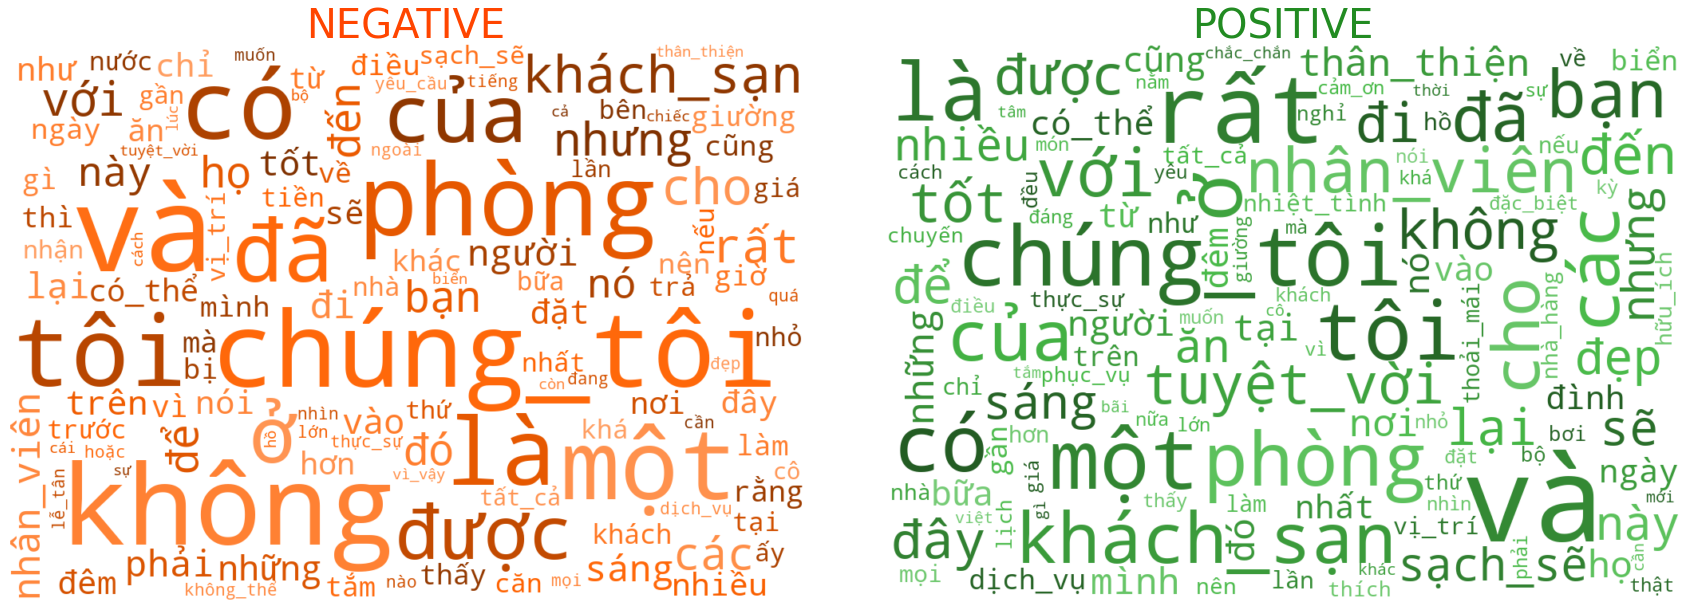

In [ ]:
docs = [negative_doc,  positive_doc] #neutral_doc,]
color_funcs = [orange_color_func, green_color_func] #green_color_func]
title_colors = ['orangered', 'forestgreen'] # 'grey']
titles = ['NEGATIVE',  'POSITIVE'] #'NEUTRAL',

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
i = 0

for doc, colorfunc in zip(docs, color_funcs):
    wordcloud = WordCloud(max_words=120,
                          width=1000,
                          height=700,
                          max_font_size=150,
                          background_color='white',
                          collocations=False).generate(doc)
    axes[i].imshow(wordcloud.recolor(color_func=colorfunc, random_state=10), interpolation='bilinear')
    axes[i].axis('off')    
    i += 1

for i, title, color in zip(range(3), titles, title_colors):
    axes[i].set_title(title, fontdict={'color': color,
                                       'fontsize': 40,
                                       'fontweight': 20})

We can see some common words in each class:

- Negative: không thể, không được, nhỏ, giá,  .. -> Class này chưa nêu rõ được các điểm tiêu cực và vẫn còn lẫn 1 số từ tích cực => Cần cải thiện lại phần xử lý văn bản

- Positive: sạch sẽ, tuyệt vời, thân thiện, cảm ơn, tốt, dịch vụ, nhân viên, vị trí, nhiệt tình ...


Word2Vec Embeddings

We will train a Word2Vec model on our data to obtain vector representations for all the unique words present in our corpus


In [ ]:
# Tokenizing comments
tokenized_comments = df['tidy_comment'].apply(lambda x: x.split())
tokenized_comments.head()


# Train a Word2Vec model, each words is a vector of length 250
word2vec_model = Word2Vec(tokenized_comments,
                          vector_size=250,
                          sample=1e-5,
                          negative=7,
                          min_count=3,
                          sg=1,
                          workers=8)

word2vec_model.train(tokenized_comments, total_examples=len(tokenized_comments), epochs=50)

# Save model for later use
word2vec_model.save('word2vec.model')

In [ ]:
# Let's see how our Word2Vec model perform

word2vec_model.wv.most_similar('ok')

[('nỏ', 0.5473443865776062),
 ('xúc_cảm', 0.5388492941856384),
 ('quện', 0.5336812138557434),
 ('tất_thảy', 0.5257147550582886),
 ('mập', 0.504344642162323),
 ('ngưởng', 0.5011708736419678),
 ('gày', 0.49503204226493835),
 ('luông', 0.49482327699661255),
 ('tĩnh_tâm', 0.4941537082195282),
 ('đâyêu', 0.4915769696235657)]

In [ ]:
def word_vectors_mean(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += word2vec_model.wv[word].reshape((1, size))
            count += 1
        except KeyError:
            continue
            
    if count != 0:
        vec /= count
    return vec

In [ ]:
wordvec_arrays = np.zeros((len(tokenized_comments), 250))

for i in range(len(tokenized_comments)):
    wordvec_arrays[i,:] = word_vectors_mean(tokenized_comments[i], 250)

features = pd.DataFrame(wordvec_arrays)
features.shape

(82380, 250)

In [ ]:
features.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,0.03,-0.15,0.01,0.04,-0.08,0.05,0.02,0.08,-0.03,-0.02,...,0.07,0.03,-0.09,0.08,0.02,0.15,-0.12,-0.04,0.07,0.03
1,0.01,-0.10,0.04,0.03,-0.11,0.06,0.05,0.08,-0.02,0.01,...,0.07,0.01,-0.09,0.05,0.05,0.11,-0.17,-0.04,0.03,0.07
2,-0.02,-0.12,0.05,0.04,-0.10,0.02,0.05,0.10,-0.03,-0.01,...,0.03,0.03,-0.12,0.08,0.03,0.14,-0.13,-0.05,0.06,0.01
3,-0.02,-0.14,-0.04,0.05,-0.05,-0.03,0.03,0.08,-0.01,-0.01,...,0.04,0.03,-0.11,0.11,0.07,0.14,-0.10,-0.05,0.07,-0.01
4,0.02,-0.11,-0.00,0.01,-0.04,0.03,-0.02,0.10,-0.02,-0.02,...,0.04,-0.03,-0.09,0.07,0.03,0.12,-0.14,-0.05,0.06,0.03


# Training model

Split combined data into train and test set again

In [ ]:
train_features = features.iloc[:30000, :]
test_features = features.iloc[30000:, :]

train_labels = df['review_class'].iloc[:30000]
test_labels = df['review_class'].iloc[30000:]

We will use the following models and then compare accuracy scores between them:
- Logistic Regression
- Random Forest
- XGBoost
- SVC

In [ ]:
models = [LogisticRegression(),
          RandomForestClassifier(),
          XGBClassifier(verbosity=0),
          SVC()
         ]

train_accuracy_scores = []
test_accuracy_scores = []
test_precision_scores = []
test_recall_scores = []

for model in models:
    
    model.fit(train_features, train_labels)
    
    train_preds = model.predict(train_features)
    test_preds = model.predict(test_features)
    
    # Accuracy score
    train_acc_score = accuracy_score(train_labels, train_preds)
    train_accuracy_scores.append(train_acc_score)
    test_acc_score = accuracy_score(test_labels, test_preds)
    test_accuracy_scores.append(test_acc_score)
    
    # Precision score
    test_prec_score = precision_score(test_labels, test_preds, average=None)
    test_precision_scores.append(test_prec_score)
    
    # Recall score
    test_rec_score = recall_score(test_labels, test_preds, average=None)
    test_recall_scores.append(test_rec_score)

In [ ]:
result_df = pd.DataFrame({
                          ('', 'Model Name'): ['Logistic Regression', 'Random Forest Classifer', 'XGBoost Classifier', 'SVC'],
                          ('', 'train_accuracy_scores'): train_accuracy_scores,
                          ('', 'test_accuracy_scores'): test_accuracy_scores,

                          ('test_precision_scores', 'negative'): np.array(test_precision_scores)[:, 0],
                          #('test_precision_scores', 'neutral'): np.array(test_precision_scores)[:, 1],
                          ('test_precision_scores', 'positive'): np.array(test_precision_scores)[:, 1],
    
                          ('test_recall_scores', 'negative'): np.array(test_recall_scores)[:, 0],
                          #('test_recall_scores', 'neutral'): np.array(test_recall_scores)[:, 1],
                          ('test_recall_scores', 'positive'): np.array(test_recall_scores)[:, 1],
                         }
                        )

result_df.style.background_gradient(cmap=sns.light_palette('#FFA04B', as_cmap=True))

SVC model has given us the best performance so far with test accuracy score of 95%. We will try to use GridSearchCV from sklearn to tune its hyperparameters

In [ ]:
svc_model = models[3]

params = {'C': [1.0, 10],
          'degree': [3, 4],
          'kernel': ['rbf']
          }

In [ ]:
gridsearch_clf = GridSearchCV(svc_model,
                              param_grid=params,
                              n_jobs=6,
                              verbose=3)

In [ ]:
gridsearch_clf.fit(train_features, train_labels)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  16 out of  20 | elapsed: 26.2min remaining:  6.5min
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed: 30.3min finished


GridSearchCV(estimator=SVC(), n_jobs=6,
             param_grid={'C': [1.0, 10], 'degree': [3, 4], 'kernel': ['rbf']},
             verbose=3)

In [ ]:
print("SVC best parameters:", gridsearch_clf.best_params_)
print("SVC best accuracy score:", gridsearch_clf.best_score_)

SVC best parameters: {'C': 10, 'degree': 3, 'kernel': 'rbf'}
SVC best accuracy score: 0.8551666666666666


Let's check out best model in detail

In [ ]:
# Get the best model from GridSearch
final_model = gridsearch_clf.best_estimator_

In [ ]:
final_preds = final_model.predict(test_features)

In [ ]:
print("CONFUSION MATRIX:\n", confusion_matrix(test_labels, final_preds))
print("-"*55 + "\n" + "CLASSIFICATION REPORT:" + "\n" + classification_report(test_labels, final_preds))

CONFUSION MATRIX:
 [[3958  684]
 [ 726 4557]]
-------------------------------------------------------
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    negative       0.85      0.85      0.85      4642
    positive       0.87      0.86      0.87      5283

    accuracy                           0.86      9925
   macro avg       0.86      0.86      0.86      9925
weighted avg       0.86      0.86      0.86      9925



Take a look at comments were wrongly predicted

In [ ]:
#df['label_pred'] = final_preds

#df[df.review_class != df.label_pred].sample(10, random_state=17)

We can see some comments have true labels that don't match the comment's content  
For example, the comment at index __14586__ has "positive" label but the content is more "neutral" (model's prediction).

In [ ]:
#test_df.iloc[14586]